Testing Stardist for nuclear segmentation
1. Load the pretrained Stardist model
2. Load a z-stack and max project
3. Test segmentation with Stardist
4. Loop to segment all the max projected images

1. Load the pretrained Stardist model

In [14]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt


# loads a pretrained StarDist2D model for nucleus segmentation
model = StarDist2D.from_pretrained('2D_versatile_fluo')


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2.  Load a max project image

(512, 512)


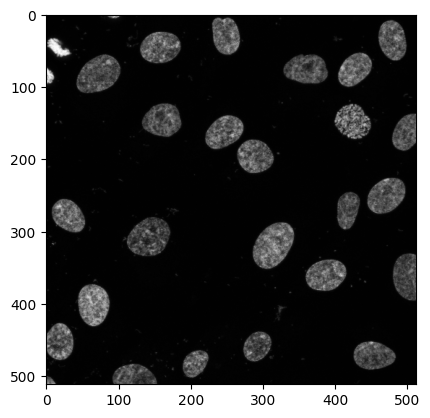

In [20]:
import zarr
from imageio import imread

#open zarr file in read mode
z = zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")

#visualize an image
treatment = "DMSO"
# Access the first image in the 'max' group for the selected treatment
image = z[treatment]["max"][0][0]
print(image.shape)
plt.imshow(image, cmap="gray")




In [21]:
z = zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")
treatments=list(z.keys())
len(treatments)
print(treatments)
treatment = "DMSO"
groups = list(z[treatment].keys())
print(groups)
z_stack= z[treatment][groups[0]]
print(z_stack.shape)

['1uMdoxo', 'DMSO', '5uMflavo', '800nMActD', '8nMActD']
['raw', 'max']
(115, 15, 3, 512, 512)


3. Test segmentation with Stardist

int32
(512, 512)


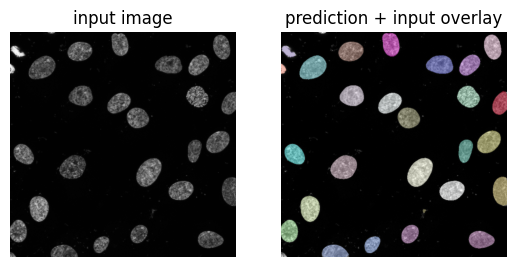

In [24]:
#get maxprj image
image = z[treatment]["max"][0][0]
#segment using the stardist model
labels, _ = model.predict_instances(normalize(image))

plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=image))
plt.axis("off")
plt.title("prediction + input overlay")

print(labels.dtype)
print(labels.shape)

4. Loop to segment all the max projected images

In [28]:
from tqdm import tqdm

treatments = list(z.keys())
sample_image = z[treatments[0]]['max'][0][0]

for treatment in treatments:
    num_images = z[treatment]['max'].shape[0]
    treatment_mask_array = np.zeros((num_images, sample_image.shape[0], sample_image.shape[1]), dtype=np.int32)
    print(f"Segmenting nuclei for Treatment: {treatment}, Group: max")
    for i in tqdm(range(num_images)):
        image = z[treatment]['max'][i][0]
        labels, _ = model.predict_instances(normalize(image))
        treatment_mask_array[i] = labels
        i += 1
    print(f"Finished segmenting nuclei for Treatment: {treatment}, Group: max, array shape: {treatment_mask_array.shape}")
    zarr.create_array(store="/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", name=f"{treatment}/masks", data= treatment_mask_array)



Segmenting nuclei for Treatment: 10uMmg132, Group: max


100%|██████████| 115/115 [00:43<00:00,  2.67it/s]


Finished segmenting nuclei for Treatment: 10uMmg132, Group: max, array shape: (115, 512, 512)
Segmenting nuclei for Treatment: 5uMflavo, Group: max


100%|██████████| 115/115 [00:45<00:00,  2.54it/s]


Finished segmenting nuclei for Treatment: 5uMflavo, Group: max, array shape: (115, 512, 512)
Segmenting nuclei for Treatment: CX5461, Group: max


100%|██████████| 115/115 [00:46<00:00,  2.47it/s]


Finished segmenting nuclei for Treatment: CX5461, Group: max, array shape: (115, 512, 512)
Segmenting nuclei for Treatment: 8nMActD, Group: max


100%|██████████| 115/115 [00:45<00:00,  2.51it/s]


Finished segmenting nuclei for Treatment: 8nMActD, Group: max, array shape: (115, 512, 512)
Segmenting nuclei for Treatment: 10uMwort, Group: max


100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


Finished segmenting nuclei for Treatment: 10uMwort, Group: max, array shape: (115, 512, 512)
Segmenting nuclei for Treatment: DMSO, Group: max


100%|██████████| 115/115 [00:46<00:00,  2.46it/s]


Finished segmenting nuclei for Treatment: DMSO, Group: max, array shape: (115, 512, 512)
Segmenting nuclei for Treatment: 800nMActD, Group: max


100%|██████████| 145/145 [01:08<00:00,  2.13it/s]


Finished segmenting nuclei for Treatment: 800nMActD, Group: max, array shape: (145, 512, 512)
Segmenting nuclei for Treatment: 1uMdoxo, Group: max


100%|██████████| 115/115 [00:49<00:00,  2.31it/s]


Finished segmenting nuclei for Treatment: 1uMdoxo, Group: max, array shape: (115, 512, 512)


5. Check masks produced by the loop

int32
(512, 512)


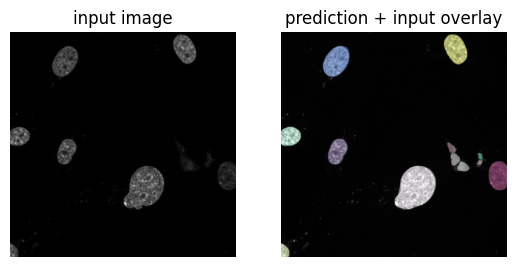

In [34]:
z = zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")
treatment = "1uMdoxo"
#get maxprj image
image = z[treatment]["max"][0][0]
mask = z[treatment]["masks"][0]

plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(mask, img=image))
plt.axis("off")
plt.title("prediction + input overlay")

print(mask.dtype)
print(mask.shape)

6. Check masks and images using Napari